# PROJET DEEP LEARNING

**SAWADOGO Issa**  
**KPOGNON Koffi**  
**Fomba Abdou**

# Introduction

### Ce projet vise à résoudre le problème de la classification automatique d'images naturelles en utilisant le Intel Image Classification Dataset de Kaggle. Ce jeu de données se compose de près de 25 000 images réparties en six classes distinctes : 'buildings', 'forest', 'glacier', 'mountain', 'sea' et 'street'. L'objectif central de cette étude est de concevoir, d'entraîner et d'évaluer des modèles de Deep Learning pour classer ces scènes avec une précision optimale. Le projet explore l'application des réseaux de neurones convolutionnels (CNN) et du transfert de connaissances afin de relever des défis pratiques tels que la variabilité visuelle et la confusion entre classes similaires. Enfin, l'approche combine une évaluation quantitative des performances avec une analyse qualitative, utilisant des techniques comme la visualisation Grad-CAM pour comprendre les décisions du modèle et améliorer sa robustesse.

## Importation de librairies

In [66]:
!pip install openml

In [67]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import openml as oml
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

## Chargement et exploration de la base

#### Chargement des données d'entrainement et de test

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.

Les 6 classes de la base de données sont : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


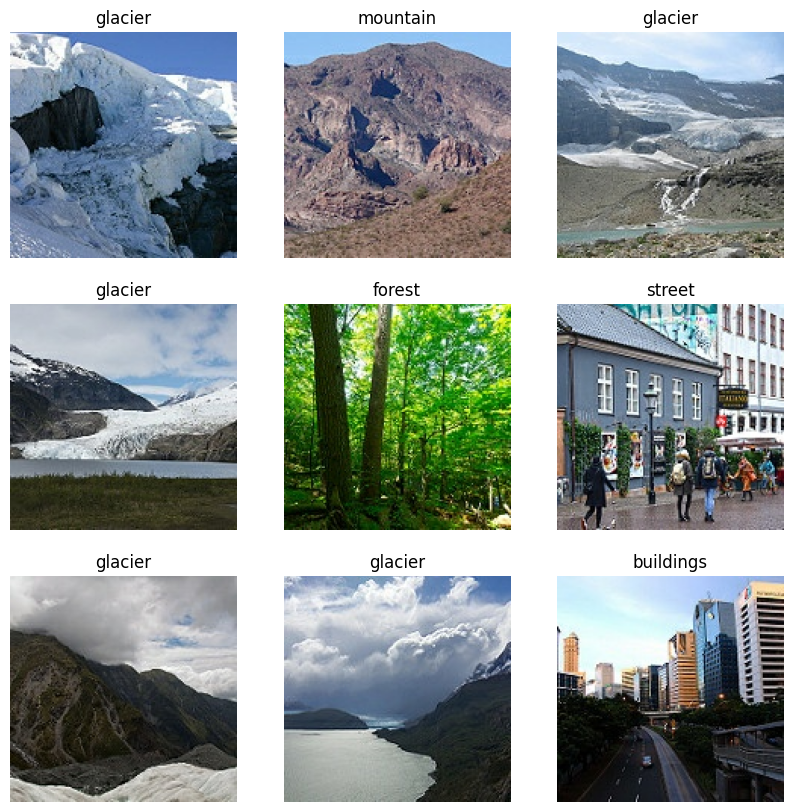


Les données sont chargées et normalisées. Prêtes pour l'entraînement d'un modèle.
Nombre de lots dans le jeu de données d'entraînement : 439
Nombre de lots dans le jeu de données de test : 94


In [68]:
# Les chemins d'accès aux dossiers d'entraînement, de test et de prédiction
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/"

# Paramètres de chargement
image_size = (150, 150) 
batch_size = 32        

# Les données d'entraînement
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size
)

# Les données de test
test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size
)

# Affichage de la structure des données
class_names = train_dataset.class_names
print("\nLes 6 classes de la base de données sont :", class_names)

# Visualisation d'un lot d'images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # Prend un seul lot
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.show()

# Normalisation des données

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

print("\nLes données sont chargées et normalisées. Prêtes pour l'entraînement d'un modèle.")

# Affichage des informations pour vérifier que tout est bien chargé
print(f"Nombre de lots dans le jeu de données d'entraînement : {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Nombre de lots dans le jeu de données de test : {tf.data.experimental.cardinality(test_dataset).numpy()}")

####  Chargement des données de prédiction

In [69]:
import glob 

# Récupération de la liste de tous les fichiers d'image dans le dossier de prédiction
image_paths = glob.glob(os.path.join(pred_dir, "*.jpg"))
print(f"\nNombre d'images de prédiction trouvées : {len(image_paths)}")

# Création d'une liste vide pour stocker les images traitées
pred_images = []

# Chargement et prétraitement de chaque image
for image_path in image_paths:
    img = tf.keras.utils.load_img(image_path, target_size=image_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    pred_images.append(img_array)

# Concaténons toutes les images en un seul tableau NumPy
if pred_images:
    pred_data = np.array(pred_images)
    print(f"Forme du tableau de données de prédiction : {pred_data.shape}")
else:
    print("Aucune image de prédiction n'a été chargée.")
    pred_data = np.array([])


Nombre d'images de prédiction trouvées : 7301
Forme du tableau de données de prédiction : (7301, 150, 150, 3)


### Distribution des données d'entrainement et de test

#### Données d'entrainement

mountain: 2512 images
street: 2382 images
buildings: 2191 images
sea: 2274 images
forest: 2271 images
glacier: 2404 images


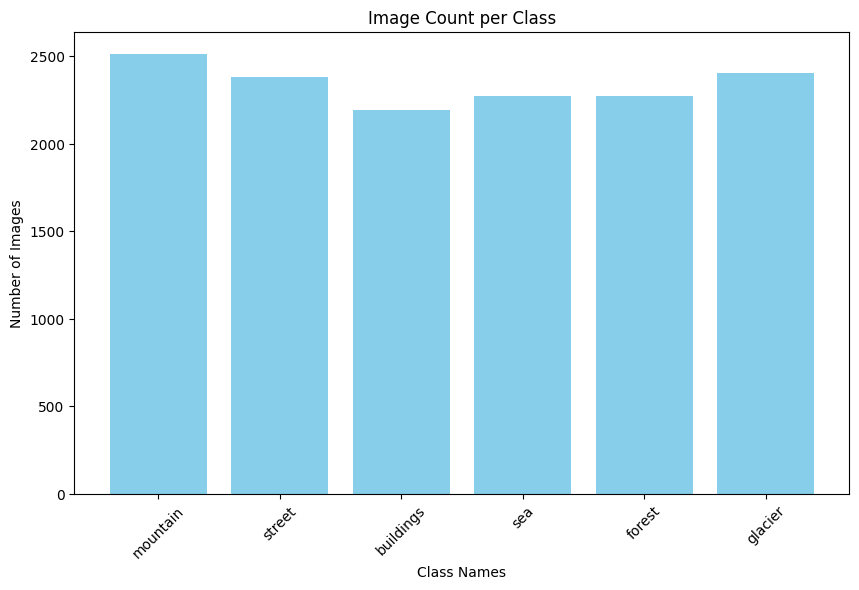

In [70]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

#### Données de test

mountain: 525 images
street: 501 images
buildings: 437 images
sea: 510 images
forest: 474 images
glacier: 553 images


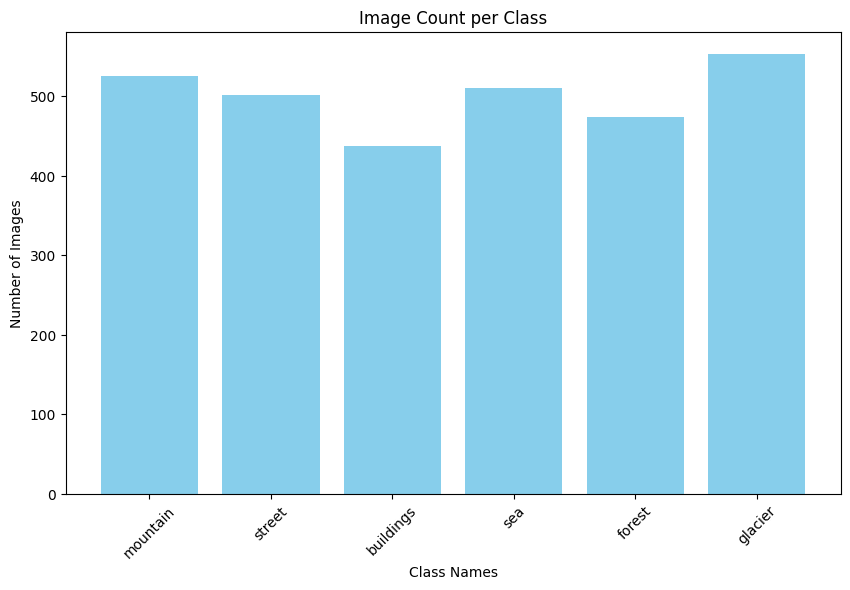

In [63]:
class_counts = {}
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Modèle simple

### Définition du modèle

In [71]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


# 2. Conception du modèle CNN adapté
model = models.Sequential()
# Input layer adapté à 150x150x3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle

In [72]:
from tensorflow.keras.optimizers import Adam

learning_rate = 1e-4  

# 3. Compilation du modèle

optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [EarlyStopping(patience=8, monitor='val_loss', mode='min', verbose=1)]

history = model.fit(
    train_dataset,
    epochs=30,
    batch_size=63,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5059 - loss: 1.2551 - val_accuracy: 0.6713 - val_loss: 0.8788
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7161 - loss: 0.7730 - val_accuracy: 0.7470 - val_loss: 0.7004
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7759 - loss: 0.6368 - val_accuracy: 0.7673 - val_loss: 0.6456
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8010 - loss: 0.5652 - val_accuracy: 0.7913 - val_loss: 0.5906
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8297 - loss: 0.4975 - val_accuracy: 0.7987 - val_loss: 0.5664
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8437 - loss: 0.4552 - val_accuracy: 0.7870 - val_loss: 0.5887
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8664 - loss: 0.4067 - val_accuracy: 0.8133 - val_loss: 0.5182
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8700 - loss: 0.3823 - val_acc

Max val_acc 0.8173333406448364


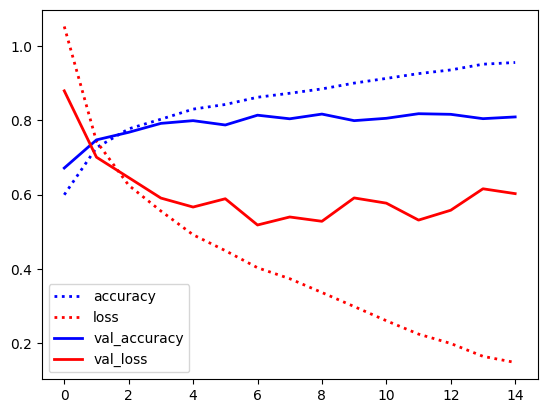

In [73]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

# Regularisation avec le dropout

In [114]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 6

# Créons l'architecture du modèle CNN
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
from tensorflow.keras.optimizers import Adam

learning_rate = 6e-4

# Compilation du modèle
optimizer = adam(learnin_rate=learning_rate) 

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Entraînement du modèle
callbacks = [
    EarlyStopping(patience=11, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [117]:
# Entraînement du modèle avec les datasets
history = model.fit(   
    train_dataset,
    epochs=50, 
    batch_size=63,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.4227 - loss: 1.4796 - val_accuracy: 0.6750 - val_loss: 0.9178
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6938 - loss: 0.8090 - val_accuracy: 0.7517 - val_loss: 0.6769
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7651 - loss: 0.6392 - val_accuracy: 0.7823 - val_loss: 0.6057
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7985 - loss: 0.5487 - val_accuracy: 0.7617 - val_loss: 0.6573
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8226 - loss: 0.4815 - val_accuracy: 0.8117 - val_loss: 0.5501
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8552 - loss: 0.3968 - val_accuracy: 0.8467 - val_loss: 0.4636
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8680 - loss: 0.3658 - val_accuracy: 0.8333 - val_loss: 0.4979
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8799 - loss: 0.3183 - val_

Max val_acc 0.846666693687439


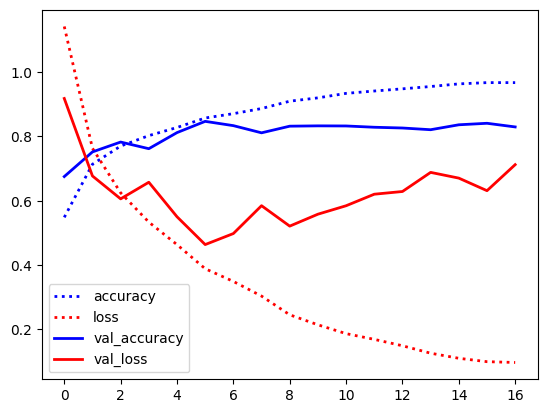

In [118]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

# Évaluation de la performance finale du modèle sur le jeu de test

Évaluation finale sur le jeu de test...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8263 - loss: 0.7586
Perte sur le jeu de test: 0.7121
Précision sur le jeu de test: 0.8293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━

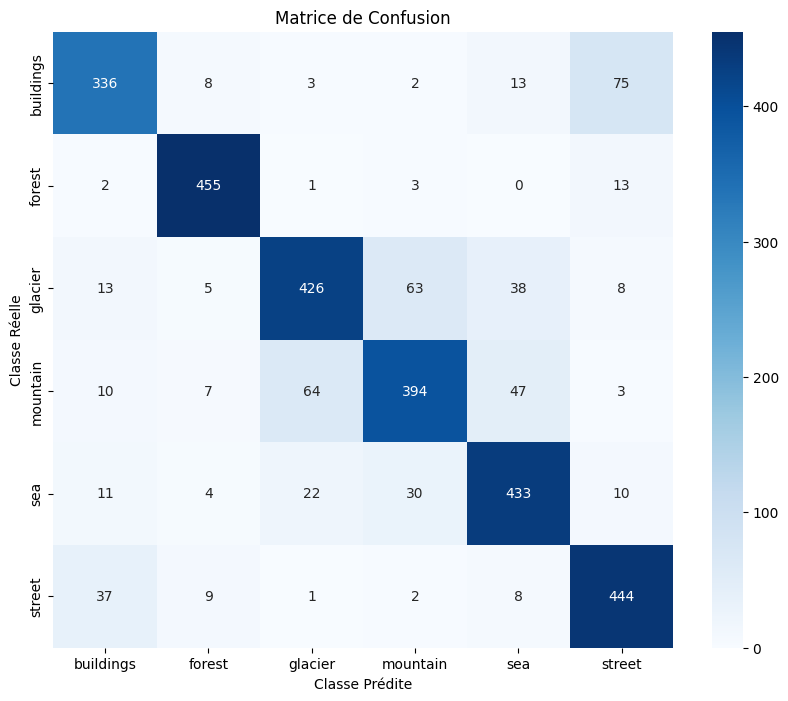

In [121]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluation de base du modèle

print("Évaluation finale sur le jeu de test...")
loss, accuracy = model.evaluate(test_dataset)
print(f"Perte sur le jeu de test: {loss:.4f}")
print(f"Précision sur le jeu de test: {accuracy:.4f}")

# Générons les prédictions et les étiquettes réelles
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(model.predict(images))

y_pred = np.argmax(np.array(y_pred_probs), axis=1)

# Rapport de classification (Précision, Rappel, F1-Score)

print("\n--- Rapport de Classification ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice de Confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')
plt.show()

# Technique d'augmentation des données

### 1ère Technique avec ImageDataGenerator

Found 14034 images belonging to 6 classes.


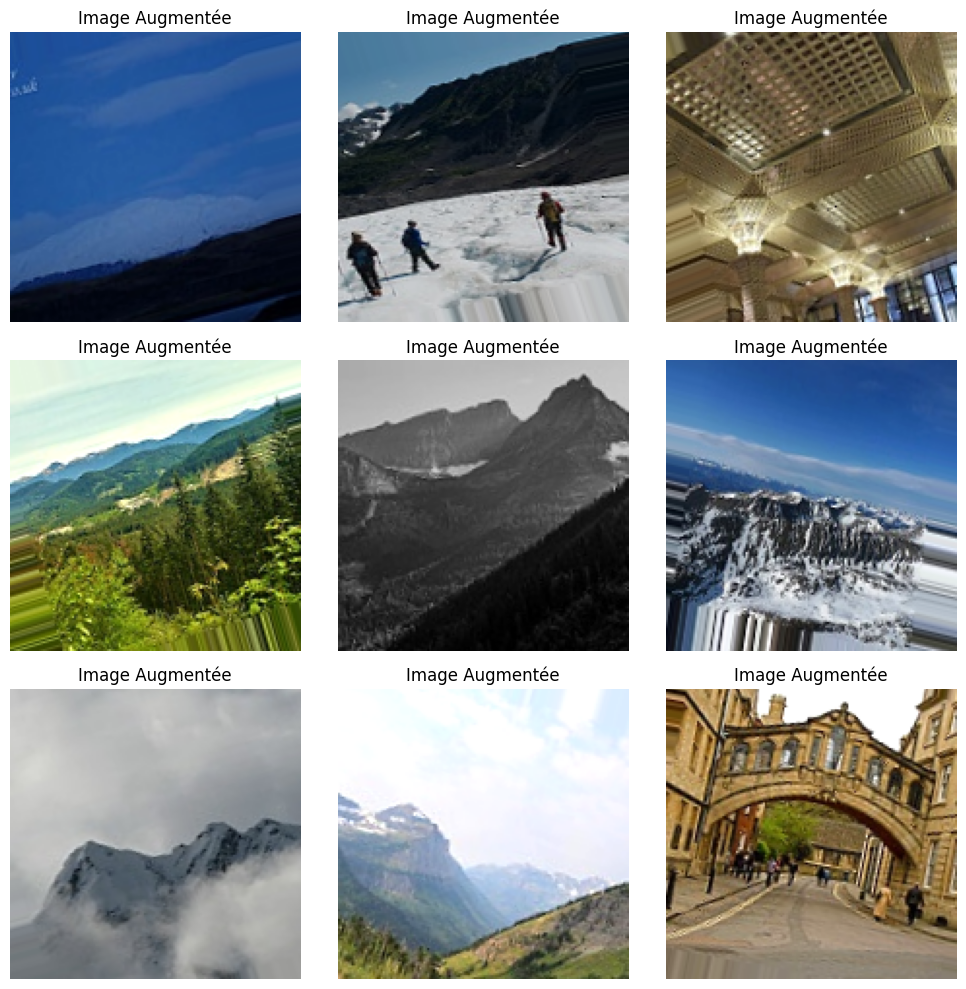

In [122]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

# Générateur d'images avec les transformations
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotation de l'image de 20 degrés au maximum
    width_shift_range=0.1,      # Décalage horizontal de 10%
    height_shift_range=0.1,     # Décalage vertical de 10%
    shear_range=0.2,            # Déformation de l'image
    zoom_range=0.2,             # Zoom aléatoire
    horizontal_flip=True,       # Retournement horizontal (très pertinent)
    brightness_range=[0.8, 1.2], # Variation de la luminosité
    rescale=1./255              # Normalisation des valeurs de pixels
)

# Utilisons le générateur pour charger les images
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Affichage de 9 exemples d'images augmentées
plt.figure(figsize=(10, 10))
for i in range(9):
    batch = next(train_generator)
    image = batch[0][0] 
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title("Image Augmentée")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Définition des chemins d'accès aux données sur Kaggle
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"

# Créons les générateurs d'images pour l'entraînement et la validation
train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'         
)

# Générateur de validation (sans augmentation des données, seulement la normalisation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Chargeons les données avec les générateurs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

learning_rate= 4e-4

optimizer=Adam(learning_rate=learning_rate)

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=50,
    batch_size= 70,
    validation_data=validation_generator,
    callbacks=callbacks
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 106s 230ms/step - accuracy: 0.4706 - loss: 1.3927 - val_accuracy: 0.6423 - val_loss: 0.9719
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 96s 218ms/step - accuracy: 0.6723 - loss: 0.8711 - val_accuracy: 0.7110 - val_loss: 0.7722
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 235ms/step - accuracy: 0.7274 - loss: 0.7426 - val_accuracy: 0.8073 - val_loss: 0.5707
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 234ms/step - accuracy: 0.7690 - loss: 0.6483 - val_accuracy: 0.8107 - val_loss: 0.5539
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.7810 - loss: 0.6052 - val_accuracy: 0.8167 - val_loss: 0.5318
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 100s 227ms/step - accuracy: 0.7978 - loss: 0.5519 - val_accuracy: 0.8230 - val_loss: 0.5161
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 110s 250ms/step - accuracy: 0.8026 - loss: 0.5470 - val_accuracy: 0.8463 - val_loss: 0.4400
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 234ms/step - accuracy: 0.8109 - 

Max val_acc 0.8813333511352539


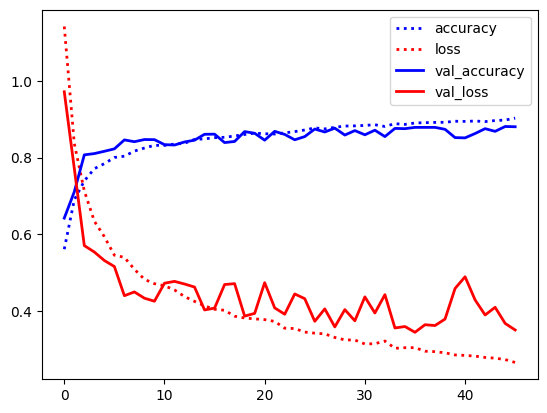

In [128]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

### 2 ème Technique avec Keras preprocessing layers

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Définissons les chemins d'accès aux données sur Kaggle
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"

# Paramètres
img_size = (150, 150)
batch_size = 32

# Chargeons les datasets (sans ImageDataGenerator)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Normalisation + Prétraitement des pixels (0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Pipeline d’augmentation (data augmentation via Keras layers)
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

# Appliquer normalisation et augmentation aux datasets
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(normalization_layer(x)), y),
                                  num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y),
                              num_parallel_calls=AUTOTUNE)

# Optimiser le pipeline (préchargement + cache en RAM)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Définir le modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

learning_rate= 4e-4

optimizer=Adam(learning_rate=learning_rate)

# Compiler le modèle
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Entraînement
history = model.fit(
    train_dataset,
    epochs=50,
    batch_size= 70,
    validation_data=val_dataset,
    callbacks=callbacks
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.3494 - loss: 1.5464 - val_accuracy: 0.5060 - val_loss: 1.2841
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5767 - loss: 1.0837 - val_accuracy: 0.5850 - val_loss: 1.1323
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6382 - loss: 0.9619 - val_accuracy: 0.5007 - val_loss: 1.3820
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6806 - loss: 0.8510 - val_accuracy: 0.6580 - val_loss: 0.9762
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7322 - loss: 0.7294 - val_accuracy: 0.6850 - val_loss: 0.8943
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7832 - loss: 0.5965 - val_accuracy: 0.6627 - val_loss: 1.0257
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8168 - loss: 0.4966 - val_accuracy: 0.6647 - val_loss: 1.0240
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8670 - loss: 0.3707 - val_acc

Max val_acc 0.6850000023841858


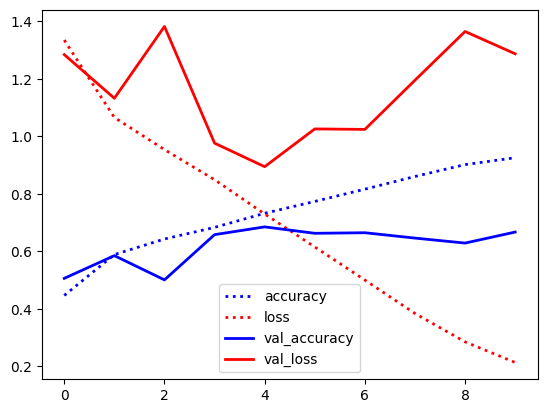

In [169]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

### Intégrons le transfer learning 

In [129]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définissons les paramètres pour le redimensionnement
image_size = (224, 224)
batch_size = 32

# Utilisons ImageDataGenerator pour charger et redimensionner les images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [135]:
IMG_SIZE_TL = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE_TL,   
    batch_size=32,
    validation_split=0.15,
    subset="training",
    seed=42
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE_TL,
    batch_size=32,
    validation_split=0.15,
    subset="validation",
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE_TL,
    batch_size=32
)


from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.
Found 3000 files belonging to 6 classes.


In [136]:
model.summary()

# Entraînement du modèle avec le nouveau classificateur
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint(filepath='vgg16_best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 48s 121ms/step - accuracy: 0.7207 - loss: 1.2889 - val_accuracy: 0.8893 - val_loss: 0.3254
Epoch 2/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.8710 - loss: 0.3622 - val_accuracy: 0.8940 - val_loss: 0.2944
Epoch 3/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.8908 - loss: 0.3055 - val_accuracy: 0.8993 - val_loss: 0.2866
Epoch 4/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9007 - loss: 0.2679 - val_accuracy: 0.8900 - val_loss: 0.3046
Epoch 5/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9102 - loss: 0.2445 - val_accuracy: 0.8960 - val_loss: 0.2885
Epoch 6/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9117 - loss: 0.2337 - val_accuracy: 0.9033 - val_loss: 0.2900
Epoch 7/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9160 - loss: 0.2271 - val_accuracy: 0.8987 - val_loss: 0.2999
Epoch 8/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.9180 - loss: 0.2113 -

Max val_acc 0.9066666960716248


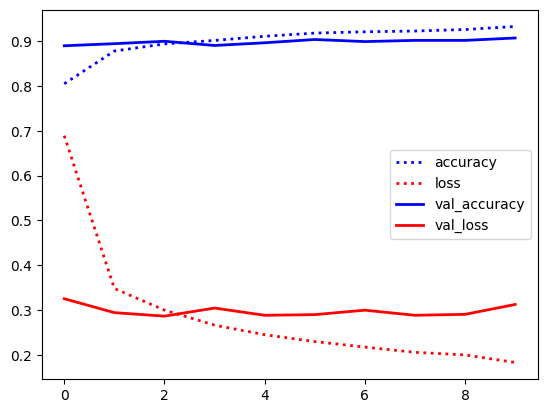

In [142]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

In [145]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Chargement du modèle de base pré-entraîné (ResNet50)

base_model = ResNet50(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Gèle des couches du modèle de base
base_model.trainable = False

# Construction du nouveau modèle en ajoutant les couches de classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax') 
])

# Compilation et entraînement du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Entraînement du modèle avec le nouveau classificateur
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint(filepath='resnet50_best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=20,
    batch_size=63,
    validation_data=test_dataset,
    callbacks=callbacks
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.2702 - loss: 1.6946 - val_accuracy: 0.4610 - val_loss: 1.3402
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.4373 - loss: 1.3427 - val_accuracy: 0.5417 - val_loss: 1.1873
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.4929 - loss: 1.2218 - val_accuracy: 0.5930 - val_loss: 1.0778
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5360 - loss: 1.1456 - val_accuracy: 0.5913 - val_loss: 1.0272
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5472 - loss: 1.1065 - val_accuracy: 0.6067 - val_loss: 1.0115
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5743 - loss: 1.0602 - val_accuracy: 0.6393 - val_loss: 0.9637
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5748 - loss: 1.0477 - val_accuracy: 0.6223 - val_loss: 0.9467
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5866 - loss: 1.0399 - 

In [ ]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

In [146]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory

# Chargement du modèle de base pré-entraîné (MobileNetV2)

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Gèle des couches du modèle de base

base_model.trainable = False

# Construction du modèle complet
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Réduit les cartes de caractéristiques en un seul vecteur
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax') # La nouvelle couche de classification pour nos 6 classes
])

# Compilation et entraînement du modèle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Entraînement du modèle avec le nouveau classificateur
history = model.fit(
    train_dataset,
    epochs=20, 
    batch_size=65,
    validation_data=test_dataset
)

/tmp/ipykernel_36/4169432650.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.7992 - loss: 0.5613 - val_accuracy: 0.8943 - val_loss: 0.2780
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8925 - loss: 0.3050 - val_accuracy: 0.8997 - val_loss: 0.2680
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8975 - loss: 0.2777 - val_accuracy: 0.8977 - val_loss: 0.2859
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9036 - loss: 0.2526 - val_accuracy: 0.9023 - val_loss: 0.2621
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9139 - loss: 0.2324 - val_accuracy: 0.8963 - val_loss: 0.2869
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9177 - loss: 0.2238 - val_accuracy: 0.9047 - val_loss: 0.2585
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9177 - loss: 0.2161 - val_accuracy: 0.9090 - val_loss: 0.2672
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9217 - loss: 0.2061 - val_acc

Max val_acc 0.909333348274231


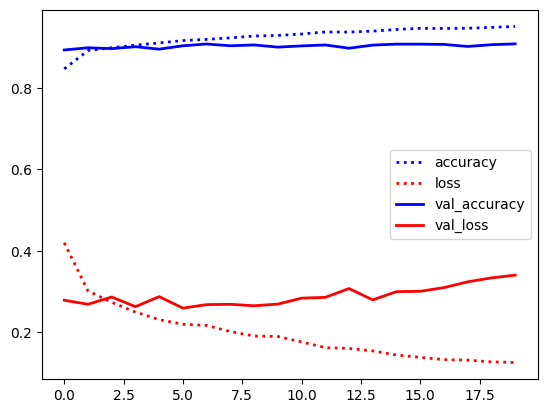

In [147]:
pd.DataFrame(history.history).plot(lw=2,style=['b:','r:','b-','r-']);
print("Max val_acc",np.max(history.history['val_accuracy']))

# 7. 1. Grad-CAM pour interprétation visuelle

In [158]:
!pip install tf-keras-vis
!pip install grad-cam

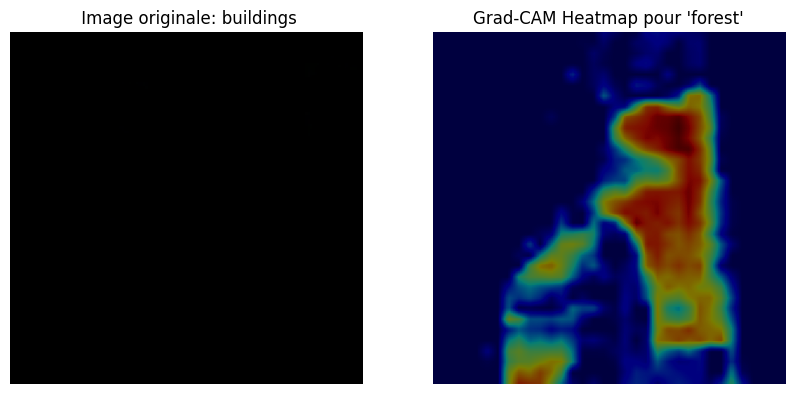

In [170]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

model_cam = Model(inputs=model.inputs, outputs=model.outputs)

class_to_analyze_index = class_names.index('forest')
score = CategoricalScore([class_to_analyze_index])

# Configuration du Grad-CAM
gradcam = Gradcam(model_cam,
                 model_modifier=ReplaceToLinear(),
                 clone=True)

images, labels = next(iter(test_dataset))
image_to_visualize = images[0]  # Take the first image in the batch


label_to_visualize = labels[0].numpy()

cam = gradcam(score,
              np.expand_dims(image_to_visualize.numpy(), axis=0),
              penultimate_layer=-1)  # -1 for the last convolutional layer

cam = tf.image.resize(cam, (image_to_visualize.shape[0], image_to_visualize.shape[1])).numpy()

# Visualisation des resultats
plt.figure(figsize=(10, 5))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(image_to_visualize.numpy().astype('uint8'))
plt.title(f" Image originale: {class_names[label_to_visualize]}")
plt.axis('off')

# Image avec le heatmap
plt.subplot(1, 2, 2)
plt.imshow(image_to_visualize.numpy().astype('uint8'))
plt.imshow(cam[0], cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM Heatmap pour '{class_names[class_to_analyze_index]}'")
plt.axis('off')

plt.show()

# 7. 2. Analyse des erreurs de classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

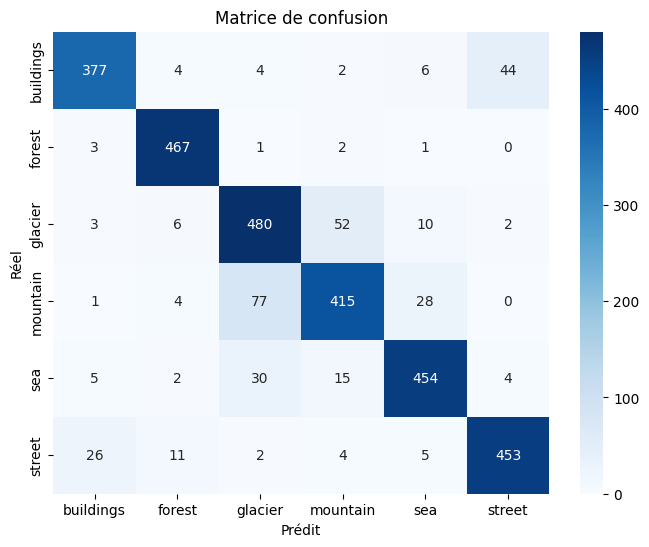

In [166]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Prédictions sur le jeu de test
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    # Correction : Ne pas utiliser argmax pour les étiquettes
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Rapport de classification
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


## Proposition des solutions d'amélioration  :
Augmentation de données : Si la confusion est due à un manque de diversité dans les données, appliquez des techniques d'augmentation de données (comme la rotation ou le zoom) aux images problématiques pour aider le modèle à généraliser.  

Réglage des hyperparamètres : Modifiez le taux d'apprentissage ou la taille des lots pour optimiser la performance du modèle.  

Transfer learning : Utilisez le transfer learning avec un modèle pré-entraîné sur un grand jeu de données comme ImageNet (par exemple, VGG16 ou ResNet50). 